# Point Landing Analyses

## This code will import two separate datasets:

- Landing information datasheet - 1 csv file
- 3D points of each landing - 1 csv file per landing

## The data will then be processed in the following order:

- Landing frame information for start, impact, and end of every given landing will be indexed
- The 3D position data will be imported, clipped, gaps interpolated, filtered, and straightened into 2D:

    1. 3D position points are placed into a dictionary stack to enable easy repeat processing of each landing
    2. 3D position is clipped using start and end frame indexing to select only time tracking occured
    3. The remaining Nan's, gaps in tracking, were interpolated using a balistically scented kalman filter
    4. A butter filter is used to smooth the interpolated data
    5. A custom straighten code is implemented to iteratively rotate the position, velocity, and acceleration of the landings so that the x and y axes are merged resulting in 2D data

## Analysis will be done to examine the following:
- Tau and tau_dot to see if mallards regulate tau in the same fashion as seen in perch landing pigeons



In [1]:
"""Data analysis and processing package imports"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import scipy.stats as stats
import scipy.cluster.vq as cluster
import statsmodels.api as sm

from scipy.signal import butter, filtfilt

from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

c:\programdata\miniconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## All functions used in this code and what they are used for:


    

In [2]:
def csv_import(filename, header = True):
    """Imports csv file as a list and separates headers from data"""
    import csv
    file = open(filename)
    readfile = csv.reader(file)
    listfile = list(readfile)
    if header == True:
        headers = listfile[0]
        data = listfile[1:]
    else:
        data = listfile
    return headers, data

In [3]:
def findiff(p, dt):
    """Second-order accurate finite difference velocites and accelerations

    Parameters
    ----------
    p = 1D array (size ntime) to take finite difference of
    dt = time step between measurements

    Returns
    ----------
    v = velocity
    a = acceleration

    Finite difference code from:
    See: https://en.wikipedia.org/wiki/Finite_difference_coefficient

    We are using 2nd order accurate central, forward, and backward finite
    differences.
    """

    n = len(p)
    v, a = np.zeros_like(p), np.zeros_like(p)

    # at the center
    for i in np.arange(1, n - 1):
        v[i] = .5 * p[i + 1] - .5 * p[i - 1]
        a[i] = p[i + 1] - 2 * p[i] + p[i - 1]

    # left boundary (forward difference)
    v[0] = -1.5 * p[0] + 2 * p[1] - .5 * p[2]
    a[0] = 2 * p[0] - 5 * p[1] + 4 * p[2] - p[3]

    # right boundary (backward differences)
    v[-1] = 1.5 * p[-1] - 2 * p[-2] + .5 * p[-3]
    a[-1] = 2 * p[-1] - 5 * p[-2] + 4 * p[-3] - p[-4]

    return v / dt, a / dt**2

In [4]:
def _sub3(a1, a2, a3):
    """Construct a 9x9 matrix given the upper, middle, and lower submatrices"""
    M = np.zeros((9, 9))
    M[0:3, 0:3] = a1
    M[3:6, 3:6] = a2
    M[6:9, 6:9] = a3
    return M

In [5]:
def _hx(x):
    """Measurement function. Constructs a 3 x 9 measurement matrix that
    maps from physical to measurement space. These are the same for us
    """
    H = np.zeros((3, 9))
    H[0, 0] = 1
    H[1, 3] = 1
    H[2, 6] = 1
    return np.dot(H, x)

In [6]:
def _fx(x, dt):
    """State transition matrix from x(k) to x(k + 1). 
    This is simply:
    x1 = x0 + dt * v0 + .5 * a0^2
    v1 = v1 + dt * a0
    a1 = a0
    """
    f = np.array([[1, dt, .5 * dt**2],
                  [0, 1, dt],
                  [0, 0, 1]])
    F = _sub3(f, f, f)
    return np.dot(F, x)

In [7]:
def ukf(pr, fs, meas_noise):
    """Use an unscented Kalman filter to smooth the data and predict
    positions px, py, pz when we have missing data

    Parameters
    ----------
    pr = (ntime x nmark x 3) raw data array in m
    fs = sampling rate
    meas_noise = measurement noise (from Qualisys), default=3

    Returns
    ----------
    out = dict that holds filtered position and calculated velocity
        and accleration. Keys are as follows:
        p, v, a: pos, vel, acc after RTS smoothing. These are the values
            to fill in the missing data gaps
        nans: (ntime x nmark) bool array that stores where we have bad values
    """
    
    ntrials, ntime, ncoor = pr.shape

    g = 9.810  # m/s^2
    dim_x = 9  # tracked variables px, vx, ax, py, vy, ay, pz, vz, az
    dim_z = 3  # measured variables px, py, pz
    dt = 1 / fs

    # state uncertainty matrix (measurement noise)
    R = meas_noise**2 * np.eye(dim_z)

    # process uncertainty matrix (effect of unmodeled behavior)
    sigx, sigy, sigz = .5 * g, .5 * g, .5 * g
    qx = Q_discrete_white_noise(3, dt=dt, var=sigx**2)
    qy = Q_discrete_white_noise(3, dt=dt, var=sigy**2)
    qz = Q_discrete_white_noise(3, dt=dt, var=sigz**2)
    Q = _sub3(qx, qy, qz)

    # uncertainty covariance matrix
    p0 = np.diag([1, 500, 2 * g])**2
    P = _sub3(p0, p0, p0)

    # store the data in 3D arrays
    pf, vf, af = pr.copy(), pr.copy(), pr.copy()  # for after RTS smoothing
    pf0, vf0, af0 = pr.copy(), pr.copy(), pr.copy()  # for original pass
    nans = np.zeros((ntime, ntrials)).astype(np.int)

    # indices for ntime x 9 arrays to get pos, vel, and acc
    pos_idx, vel_idx, acc_idx = [0, 3, 6], [1, 4, 7], [2, 5, 8]

    for j in np.arange(ntrials):
        zs = pr[j, :].copy()

        # store the nan values
        idx = np.where(np.isnan(zs[:, 0]))[0]
        nans[idx, j] = 1

        # batch_filter needs a list, with a nan values as None
        zs = zs.tolist()
        for ii in idx:
            zs[ii] = None

        # initial conditions for the smoother
        x0 = np.zeros(9)
        x0[pos_idx] = zs[0]
        x0[vel_idx] = 0, 500, 1000  # guess v0, mm/s
        x0[acc_idx] = .1 * g, .1 * g, -.5 * g  # guess a0, mm/s^2

        # how to calculate the sigma points
        msp = MerweScaledSigmaPoints(n=dim_x, alpha=1e-3, beta=2, kappa=0)

        # setup the filter with our values
        kf = UKF(dim_x, dim_z, dt, _hx, _fx, msp)
        kf.x, kf.P, kf.R, kf.Q = x0, P, R, Q

        # filter 'forward'
        xs, covs = kf.batch_filter(zs)

        # apply RTS smoothing
        Ms, Ps, Ks = kf.rts_smoother(xs, covs, dts=dt)

        # get data out of the (ntime x 9) array
        pf0[j, :] = xs[:, pos_idx]
        vf0[j, :] = xs[:, vel_idx]
        af0[j, :] = xs[:, acc_idx]

        pf[j, :] = Ms[:, pos_idx]
        vf[j, :] = Ms[:, vel_idx]
        af[j, :] = Ms[:, acc_idx]

    # finally store everything in a dictionary
    out = {'p': pf, 'v': vf, 'a': af, 'pf0': pf0, 'vf0': vf0, 'af0': af0,
           'nans': nans, 'xs': xs, 'covs': covs, 'zs': zs, 'x0': x0}
    return out

In [8]:
def index_notnan(trial, frame):
    """Find nan values within each landing and create an index array of them"""
    if not np.isnan(frame[trial,0]):
        return trial
    else:
        return index_notnan(trial+1, frame)

In [9]:
def fill_ukf_mg(pr, fs, meas_noise):
    """Fill-in missing data from the output of ukf. This only applies the
    filter to those arrays that are missing data.

    Parameters
    ----------
    pr : array, (ntime x nmark x 3)
        raw position data
    fs : float
        Sampling rate
    meas_noise : float
        Measurement noise in mm (output from Qualisys)

    Returns
    ----------
    pfill : array, size (ntime x nmark)
        Array that holds the same (noisy) data as pr, except that
        nan locations have been filled with our predictions.
    nans : array, size (ntime x nmark)
        int array, 1's correspond to nan values
    pfill0 : array, size (ntime x nmark x 3)
        filled positions after the forward pass of the filter
        (excluding the RTS smoother).
    """

    ntrials, ntime, ncoord = pr.shape
    
    pfill = pr.copy()  
    pfill0 = pr.copy()
       
    nans = np.zeros((ntime, ntrials)).astype(np.int)
    for i in np.arange(ntrials):
        arr = np.copy(pr)[i, :, :]
        idx = np.where(np.isnan(arr[:, 0]))[0]
        nans[idx, i] = 1
        
        
        if len(idx) > 0:
            # convert to 3D array for ukf, since this function iterates
            # through all of the markers. now we have an ntime x 1 marker x
            # ncood array
            data = np.zeros((1, ntime, ncoord))
            data[0, :] = arr

            # perform the filtering
            out = ukf(data, fs, meas_noise)

            # take data from the smoothed array (output of ukf) and
            # copy over the naned values
            pfill[i, idx] = out['p'][0, idx]
            pfill0[i, idx] = out['pf0'][0, idx]

    return pfill, nans, pfill0

In [10]:
def but(pr, fs, fc, order=2, padlen=None):
    """Smooth with two passes of a Butterworth filter and calculate
    velocity and acceleration with finite differences

    Parameters
    ----------
    pr = (ntime x nmark x 3) raw data array
    fs = sampling rate
    fc = Butterworth filter cutoff frequency (pick this from a
        residual analysis)
    order = filter order (default is 2)
    padlen = padding to use in filtfilt (default is None, so use
        ntime - 1 length of padding)

    Returns
    ----------
    out = dict that holds filtered position and calculated velocity
        and accleration; also return Wn, the fraction of the Nyquist
        used to construct the filter coefficients
    """

    ntime, nmark, ncoord = pr.shape

    fny = fs / 2  # Nyquist frequency
    Wn = fc / fny  # non-dimensional fraction of the Nyquist
    dt = 1 / fs  # measurement interval

    # get the filter coefficients
    butb, buta = butter(order, Wn)

    # padlen for filtfilt
    if padlen is None:
        padlen = ntime - 1

    # iterate through each marker and coordinate, smooth, and calculate
    # velocities and accelerations
    pf, vf, af = pr.copy(), pr.copy(), pr.copy()
    for j in np.arange(nmark):
        for k in np.arange(ncoord):
            d = pr[:, j, k]
            p = filtfilt(butb, buta, d, padlen=padlen)
            v, a = findiff(p, dt)
            pf[:, j, k], vf[:, j, k], af[:, j, k] = p, v, a

    out = {'p': pf, 'v': vf, 'a': af, 'Wn': Wn}
    return out

In [11]:
def but_fcs(pr, fs, fcs, order=2, padlen=None):
    """Smooth with two passes of a Butterworth filter and calculate
    velocity and acceleration with finite differences. However, use
    difference cutoff frequencies for each marker and x, y, z
    time series.

    Parameters
    ----------
    pr = (ntime x nmark x ncoord) array
        raw data array
    fs = float
        sampling rate
    fcs = (nmark x ncoord) array
        Butterworth filter cutoff frequencies (pick this from the residual
        analysis)
    order = integer
        filter order (default is 2)
    padlen = integer or None
        padding to use in filtfilt (default is None, so use time - 1 length
        of padding)

    Returns
    ----------
    out = dict
        Holds filtered position and calculated velocity
        and accleration; also return Wns, the fraction of the Nyquist
        used to construct the filter coefficients for each marker in
        the x, y, and z positions.
    """

    ntime, nmark, ncoord = pr.shape
    dt = 1 / fs  # measurement interval

    fny = fs / 2  # Nyquist frequency
    Wns = fcs / fny  # non-dimensional fraction of the Nyquist

    # padlen for filtfilt
    if padlen is None:
        padlen = ntime - 1

    # iterate through each marker and coordinate, smooth, and calculate
    # velocities and accelerations
    pf, vf, af = pr.copy(), pr.copy(), pr.copy()
    for j in np.arange(nmark):
        for k in np.arange(ncoord):
            # construct the filter
            butb, buta = butter(order, Wns[j, k])

            # select data and perform filtering
            d = pr[:, j, k]
            p = filtfilt(butb, buta, d, padlen=padlen)
            v, a = findiff(p, dt)
            pf[:, j, k], vf[:, j, k], af[:, j, k] = p, v, a

    out = {'p': pf, 'v': vf, 'a': af, 'Wns': Wns}
    return out

In [12]:
def residual_butter(pr, fs, order=2, df=.5, fmin=1, fmax=35):
    """Calculate RMS residuals to determine a proper cutoff frequency
    for a Butterworth filtering.

    Parameters
    ----------
    pr = (ntime x nmark x 3) raw data array
    fs = sampling frequency
    order = order filter to use, default is 2
    df = difference between frequencies
    fmin = min freq to try, default is 1
    fmax = max freq to try, default is 35

    Returns
    ----------
    R = residual array of (nfreq x nmark x 3) that has the RMS residual
        for a given marker is in X, Y, and Z directions.
    fcs = array of cutoff frequencies tried
    """

    ntime, nmark, ncoord = pr.shape

    # fcs = np.linspace(fmin, fmax, nfreq)
    fcs = np.arange(fmin, fmax + .01, df)
    nfreq = len(fcs)
    R = np.zeros((nfreq, nmark, 3))

    for i, fc in enumerate(fcs):
        out = but(pr, fs, fc, order)
        R[i] = np.sqrt(np.mean((pr - out['p'])**2, axis=0))

    return R, fcs

In [13]:
def opt_cutoff(R, fcs, rsq_cutoff=.95):
    """Find an 'optimum' cutoff frequency based on the residuals.

    Parameters
    ----------
    R = (nfreq x nmark x 3) array of residuals
    fcs = cutoff frequences used
    rsq_cutoff = coefficient of determination minimum that determines the
        frequency to perform the noise fit

    Returns
    ----------
    inter = (nmark x ncoord) array of y-intercepts in mm
    fcopt = (nmark x ncoord) array of 'optimum' cutoff frequencies
    rsq = (nmark x ncoord) array of R^2 values
    flinreg = (2 x nmark x ncoord) array of the fmin, fmax values to
        construct the linear regression to get the cutoff frequency

    Notes:
    This function fits a linear line to the tail of the residual, finds
    the intercept (a residual) and the corresponding cutoff frequency
    this residual corresponds to. This is a 'rough' find, that is, it
    finds the nearest freqeuncy in the array of provided requencies and does
    not do root finding of an interpolation function, etc.

    http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    """
    from scipy.stats import linregress
    from scipy.optimize import newton
    from scipy.interpolate import interp1d

    nfreq, nmark, ncoord = R.shape

    inter = np.zeros((nmark, ncoord))
    fcopt = np.zeros((nmark, ncoord))
    rsq = np.zeros((nmark, ncoord))
    flinreg = np.zeros((2, nmark, ncoord))

    for j in np.arange(nmark):
        for k in np.arange(3):
            # res = R[idx, j, k]
            res = R[:, j, k]

            # iterative find the min freq to perform interpolation
            # step backwards through the arratriay, until rsq drops to rsq_cutoff
#            ixcut = np.inf  # if don't get into if, this will throw an error
            for mm in np.arange(nfreq - 2, 0, -1):
                slope, intercept, r_value, p_value, std_err = \
                    linregress(fcs[mm:], res[mm:])
                # print r_value**2
                if r_value**2 < rsq_cutoff:
                    ixcut = mm + 1
                    break

            # once we go under rsq_cutoff, use the previous value
            slope, intercept, r_value, p_value, std_err = \
                linregress(fcs[ixcut:], res[ixcut:])

            # optimize the cutoff frequency
            def tozero(freq_guess):
                return resid_interp(freq_guess) - intercept

            # interpolation function of the residuals
            resid_interp = interp1d(fcs, res)
            fopt_guess = fcs[np.argmin(np.abs(res - intercept))]
            fopt = newton(tozero, fopt_guess)

            # store the values
            inter[j, k] = intercept
            fcopt[j, k] = fopt
            rsq[j, k] = r_value**2
            flinreg[:, j, k] = fcs[ixcut], fcs[-1]

    return inter, fcopt, rsq, flinreg

In [14]:
def straighten_traj(pf_I, vf_I, af_I):
    """Merge 2 axes into one to create a 2D representation of a 3D landing.
    
    Parameters
    ----------
        pf_I = (ntime x ncoord) array, 3D coordinates of position
        vf_I = (ntime x ncoord) array, 3D coordinates of velocity
        af_I = 3(ntime x ncoord) array, D coordinates of acceleration
    In this case all 3D coordinates are based on the position points, which have been
    Kalman filter interpolated, 'I', and filtered based on a Butterworth filter, 'f',
    before straightening occurs
    
    Returns
    ----------
        pf_S = (ntime x ncoord) array, 2D position points; ncoord[0] is a constant, ncoord[1:2] is data
        vf_S = (ntime x ncoord) array, 2D velocity points; ncoord[0] is a constant, ncoord[1:2] is data
        af_S = (ntime x ncoord) array, 2D acceleration points; ncoord[0] is a constant, ncoord[1:2] is data
        yaw = (ntime x 1) array, rotation angle to straighten along x and y axes with intial vector
        gamma = (ntime x 1) array, glide angle (velocity vector angle)
        C_I2S = (ntime x 3 x 3), rotation matrix about yaw axis
    
    Notes:
    Interatively move through the position, velocity, 
    and acceleration data and rotate them all into alignment 
    with the initial direction vector. This enables you to merge
    2 axes (x and y in this case) why retaining the accurate 
    physical characteristics of a landing and create a 2D representation
    said landing
    """
    
    ntime = len(pf_I)
    
    # straightened CoM position
    p0 = pf_I[0]
    pf_S = pf_I.copy() - p0

    # iterate through the points a find the successive rotation angles and
    # straighten the CoM trajectory
    mus = np.zeros(ntime)
    Rmus = np.zeros((ntime, 3, 3))
    for i in np.arange(ntime):
        if i == 0:
            prev = pf_S[i]
            continue
        else:
            uu = pf_S[i] - prev
            
            mu = np.arctan2(uu[0], uu[1])  # -tan^-1(px / py)
            Rmu = np.array([[np.cos(mu), -np.sin(mu), 0],
                        [np.sin(mu),  np.cos(mu), 0],
                        [0, 0, 1]])

            mus[i] = mu
            Rmus[i] = Rmu

        # apply the rotation to each point along the spline
            for ii in np.arange(i, ntime):
                pf_S[ii] = pf_S[ii] - prev
                pf_S[ii] = np.dot(Rmu, pf_S[ii])
                pf_S[ii] = pf_S[ii] + prev
            
            prev = pf_S[i]

    # move back to start of inertial CoM position
    pf_S = pf_S + p0

    # now rotate the non-position variables

    # use the yaw angle to rotate points and velocities
    yaw = np.arctan2(-vf_I[:, 0], vf_I[:, 1])  # yaw angle
    yaw = np.unwrap(yaw)

    # rotation matrix about yaw axis
    C_I2S = np.zeros((ntime, 3, 3))

    vf_S = np.zeros_like(vf_I)
    af_S = np.zeros_like(af_I)
    for i in np.arange(ntime):
        # rotation matrix
        C_I2S[i] = np.array([[np.cos(yaw[i]), np.sin(yaw[i]), 0],
                             [-np.sin(yaw[i]),  np.cos(yaw[i]), 0],
                             [0, 0, 1]])

        # rotate them
        vf_S[i] = np.dot(C_I2S[i], vf_I[i].T).T
        af_S[i] = np.dot(C_I2S[i], af_I[i].T).T

    # glide angle based on straighted trajectory velcity down from horizontal
    # this ensures when rotated to this direction, only velocity in yhat
    gamma = -np.arctan2(vf_S[:, 2], vf_S[:, 1])  # glide angle

    return pf_S, vf_S, af_S, yaw, gamma, C_I2S


## Data import, cleaning and processing

In [15]:
"""Key constants related to data collection
    
    Constants
    ----------
        fs = frame per second for recording
        dt = frame rate in seconds
        meas_noise = maximum noise in meters for a calibration for any landing
"""
fs = 29.97
dt = 1/fs
meas_noise = 0.04

In [16]:
"""Import and create frame indices from Digitization catalog"""
# import video data catalog of all landing video info
filename = 'TestDirectory/GoPro_Digi_Catalog_Test.csv'
idx_data = pd.read_csv(filename)

# homogenize columns titles into same format 
idx_data.columns = idx_data.columns.str.strip().str.replace(' ', '_').str.lower()
idx_data = idx_data.drop(0, 0).drop(['number_of_gp_landings', 'number_of_matches'], 1)
nlandings = idx_data.index

# remove landings in which they cannot be reliably digitized or
# land on the ground (create sepearte ground index)
bad_digi = idx_data[idx_data['usable_landings'] != 1]
idx_data = idx_data.drop(bad_digi.index, axis=0)
ground_idx = idx_data[idx_data['notes'].str.contains(r'[Gg]round') == True]
idx_data = idx_data.drop(ground_idx.index, axis=0)

# update index for catalog of usable landings
ntrials, columns = idx_data.shape
new_index = np.linspace(0, ntrials, ntrials, False)
new_index = np.array(new_index + 1)
new_idx = new_index.astype(int)

idx_data.set_index(new_idx, inplace=True)
idx_data['date'] = idx_data['date'].astype(str).str.strip('.0')
idx_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 1 to 177
Data columns (total 11 columns):
date                      177 non-null object
gopro_vid_id              177 non-null object
usable_landings           177 non-null float64
sex                       177 non-null object
start_frame               177 non-null float64
impact_frame              177 non-null float64
end_frame                 177 non-null float64
rsv_match                 177 non-null float64
rsv_vid_id                40 non-null object
number_of_conspecifics    177 non-null float64
notes                     17 non-null object
dtypes: float64(6), object(5)
memory usage: 16.6+ KB


In [17]:
"""Import all landing vids and put into a data dictionary"""
data_dict = {}
for i in np.arange(ntrials):
    #use info from index catalog to find correct files
    date = idx_data['date'].iat[i]
    vid_id = idx_data['gopro_vid_id'].iat[i]
    filename = str('TestDirectory/' + date + '-digi-GP.Landing.' + vid_id + '-xyzpts.csv')
    
    # make sure no files in index catalog are missing     
    try:
        axes, data = csv_import(filename)
    except FileNotFoundError:
        print(filename)
    
    #place data into dictionary     
    data = np.array(data).astype('float64')
    data_dict[i] = {'raw':data}

In [18]:
"""Clip, interpolate, filter, and straighten each landing - save all landing data to a data dictionary"""
for i in np.arange(ntrials):
    data = data_dict[i]['raw'].copy()
    # pull start and end frames from index and caluculate appropriate impact frame based on start     
    stt = int(idx_data['start_frame'].iloc[i] - 1)
    end = int(idx_data['end_frame'].iloc[i])
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    
    # clip data based on index info     
    clip_data = np.asarray(data[stt:end, :])
    data_dict[i]['clipped'] = clip_data
    
    ntime, ncoord = clip_data.shape
    
    # prep arrays for gap interpolation (nans)     
    nans= np.zeros((ntime, ntrials)).astype(np.int)
    
    pfill = clip_data.copy()
    pfill0 = clip_data.copy()
    
    arr = np.copy(clip_data)[:, :]
    idx = np.where(np.isnan(arr[:, 0]))[0]
    nans[idx, i] = 1
    
    # if nan's present run data through Kalman filter to interpolate gaps    
    if len(idx) > 0:
        data = np.zeros((1, ntime, ncoord))
        data[0, :] = arr
        
        out = ukf(data, fs, meas_noise)
        
        pfill[idx] = out['p'][0, idx]
        pfill0[idx] = out['pf0'][0, idx]

    data_dict[i]['filtered'] = pfill
    
    # align landins with respect to initial impact    
    landing_pos = pfill[imp, :]
    pfill -= landing_pos
    
    # invert z-axis for old data where dipole was inverted     
    if i > 23:
        pfill[:,2] *= -1
    
    data_dict[i]['aligned_imp'] = pfill
    
    pr_I = pfill
    
    # run butterworth filter on landings     
    resid_array = np.zeros((ntime, 1, 3,))
    resid_array[:, 0] = pr_I
    resid, fcs = residual_butter(resid_array, fs, df=.1, fmin=0.1, fmax=10)
    inter, fcopt, rsq, flinreg = opt_cutoff(resid, fcs, rsq_cutoff=.95)
    
    out = but_fcs(resid_array, fs, fcopt)
    
    # export all Kalman filter interpolated data and butterworth filter parameters     
    data_dict[i]['pf_I'] = out['p'][:,0]
    data_dict[i]['vf_I'] = out['v'][:,0]
    data_dict[i]['af_I'] = out['a'][:,0]
    data_dict[i]['Wns'] = out['Wns'][:,0]

    data_dict[i]['resid'] = resid[:, 0]
    data_dict[i]['fcs'] = fcs
    data_dict[i]['inter'] = inter.flatten()
    data_dict[i]['fcopt'] = fcopt.flatten()
    data_dict[i]['rsq'] = rsq.flatten()
    data_dict[i]['flinreg'] = flinreg[:, 0]
    
for i in np.arange(ntrials):
    pf_I, vf_I, af_I = data_dict[i]['pf_I'], data_dict[i]['vf_I'], data_dict[i]['af_I']
    # straighten interpolated and filtered data     
    out = straighten_traj(pf_I, vf_I, af_I)
    pf_S, vf_S, af_S, yaw, gamma, C_I2S = out
    
    data_dict[i]['pf_S'] = pf_S
    data_dict[i]['vf_S'] = vf_S
    data_dict[i]['af_S'] = af_S
    data_dict[i]['yaw'] = yaw
    data_dict[i]['gamma'] = gamma
    data_dict[i]['C_I2S'] = C_I2S


In [19]:
"""Trucate landing plot start points based on an inflection point for initial descent
    
    Notes:
    Finds the change in the z-axis up to 4/5th's of the way to impact. Uses inflection points based 
    on change in the z-axis to find a point of initial descent, for which the x-intecept (frame) is 
    then exported to index catalog to enable trunctation at the point of initial descent for each landing.
"""
x_int = []
idx = np.arange(ntrials) + 1
for i in np.arange(ntrials):
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    
    pf = data_dict[i]['pf_S'].copy()
    s = pd.DataFrame(pf[:imp,2])
    imp_s = pf[imp,2]
    rows, cols = s.shape
    s = s - imp_s
    time = round(rows*0.80)
    z_dot = s[:time].diff().rolling(1).sum().dropna().abs()

    z_dot_min = z_dot.min()
    z_min = z_dot[z_dot == z_dot_min].dropna()
    x_int.append(z_min.index.values)

int_df = pd.DataFrame(x_int, index=idx)

idx_data['descent_start'] = int_df

In [23]:
# """Export 2D position, velocity, and acceleration data"""
# for i in np.arange(ntrials):
#     stt = idx_data['descent_start'].iloc[i]
#     pf_S, vf_S, af_S = data_dict[i]['pf_S'], data_dict[i]['vf_S'], data_dict[i]['af_S']
#     ex_data = np.hstack((pf_S[stt:,1:], vf_S[stt:,1:], af_S[stt:,1:]))
    
#     titles = ['pos_xy_' + str(i + 1).zfill(3), 'pos_z_' + str(i + 1).zfill(3),
#              'vel_xy_' + str(i + 1).zfill(3), 'vel_z_' + str(i + 1).zfill(3),
#              'acc_xy_' + str(i + 1).zfill(3), 'acc_z_' + str(i + 1).zfill(3)]
    
#     ex_df = pd.DataFrame(ex_data, index=None, columns=titles)
    
#     filename = 'Straightened_Landing_data_' + str(i + 1).zfill(3) + '.csv'
#     ex_df.to_csv('Straightened_Data_Export/' + filename)
    

## Data analysis

In [20]:
"""Additional packages and settings for analyses and figure generation"""
import seaborn as sns

from matplotlib import rcParams as rc
from pandas.plotting import scatter_matrix
from mpl_toolkits import mplot3d

bmap = sns.diverging_palette(255, 133, l=60, n=7, center='dark')

rc = {'pdf.fonttype':42, 'ps.fonttype':42, 'mathtext.fontset':'cm'}
sns.set('paper', 'ticks', font='Calibri', palette='deep',
        font_scale=1.5, color_codes=True, rc=rc)

%matplotlib inline

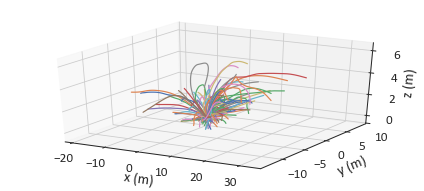

In [25]:
"""Generate 3D plot of all landing trajectories"""
fig, ax = plt.subplots()
ax = plt.axes(projection='3d')


for i in np.arange(ntrials):
    pos = data_dict[i]['pf_I'].copy()
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]

    plt.plot(x,y,z)

ax.set_xlabel('x (m)', labelpad=7)
ax.set_ylabel('y (m)', labelpad=7)
ax.set_zlabel('z (m)', labelpad=-1)
# ax.set_title('Flight trajectories in 3D')
ax.set_yticks(np.arange(-10, 11, 5))
ax.set_zticks(np.arange(0, 8, 2))
ax.axis('scaled')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('3D-177-LandingTrajectories', dpi=300)

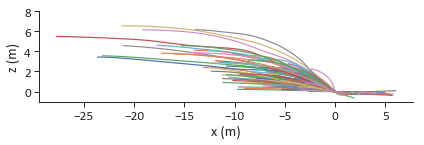

In [26]:
"""Generate a 2D plot of all landing trajectories"""
fig, ax = plt.subplots()
for i in np.arange(ntrials):
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    stt = int(idx_data['descent_start'].iloc[i])

    pf = data_dict[i]['pf_S'].copy()

    x = pf[:,1]
    y = pf[:,2]
    imp_x = pf[imp,1]
    imp_y = pf[imp,2]

    x = x - imp_x
    y = y - imp_y
    n = len(x[:])
    t = np.linspace(0,n,n,False)
    t = t/fs
    t = t-t[imp]

    plt.plot(x[stt:],y[stt:])

ax.axis('scaled')    
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
# ax.set_title('Flight trajectories in 2D')
plt.yticks(np.arange(0, 10, 2.0))

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("2D-177-LandingTrajectories_descent_only", dpi=300)

c:\programdata\miniconda3\lib\site-packages\scipy\stats\stats.py:3031: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))
c:\programdata\miniconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


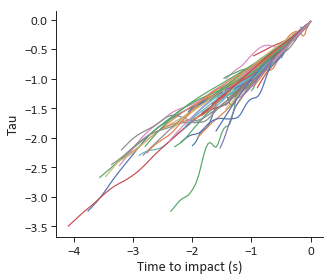

In [27]:
"""Calculation of tau, plotting, and pearson coefficient analysis to find tau_dot"""
tau_dot = []
tau_pvalues = []
pear_coef = []
tau_r2values = []

fig, ax = plt.subplots()
for i in np.arange(ntrials):        
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    stt = int(idx_data['descent_start'].iloc[i])
    
    pos = data_dict[i]['pf_S'].copy()
    vel = data_dict[i]['vf_S'].copy()

    x = pos[:imp,1]
    x =abs(x - pos[imp, 1])
    x_dot = vel[:imp,1]

    tau = (np.divide(x, x_dot))*-1
    data_dict[i]['tau'] = tau

    n = len(x)
    t = np.linspace(0,n,n,False)
    t = t/fs
    t = t-np.max(t)

    plt.plot(t[stt:], tau[stt:])

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(t[stt:], tau[stt:])
    tau_dot.append(slope)
    coef, p_value = scipy.stats.pearsonr(t[stt:], tau[stt:])
    tau_pvalues.append(p_value)
    pear_coef.append(coef)
    r2 = r_value**2
    tau_r2values.append(r2)


ax.set_ylabel('Tau')
ax.set_xlabel('Time to impact (s)')
ax.axis('scaled')
# ax.set_xlim(-0.6, 0)
# ax.set_ylim(-0.6, 0)
# ax.set_yticks(np.arange(-0.6, 0.1, 0.2))
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("Final-TauTrajectories_v01", dpi=300)

idx = np.arange(ntrials) + 1
 
idx_data['tau_dot'] = pd.Series(tau_dot, index=idx)
idx_data['pearson_coef'] = pd.Series(pear_coef, index=idx)
idx_data['tau_pvalues'] = pd.Series(tau_pvalues, index=idx)
idx_data['tau_r2values'] = pd.Series(tau_r2values, index=idx)

In [21]:
"""Find distance traveled after impact"""
dist = []
time_skim = []
for i in np.arange(ntrials):
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    
    pos = data_dict[i]['pf_S'].copy()
    pos = pos[imp:, :]
    t_skim = len(pos) * dt
    time_skim.append(t_skim)
    
    n = len(pos) - 1
    
    r_all = []
    for ii in np.arange(n):
        ith = int(ii)
        jth = int(ii+1)
        
        xi = pos[ith, 1]
        zi = pos[ith, 2]
        
        xj = pos[jth, 1]
        zj = pos[jth, 2]
        
        r = np.sqrt((xi-xj)**2 + (zi-zj)**2)
        r_all.append(r)
    dist.append(np.sum(r_all))

idx_data['distance_after_impact'] = pd.Series(dist, index=idx)
idx_data['time_skim'] = pd.Series(time_skim, index=idx)

In [22]:
idx_data['time_skim'].describe()

count    177.000000
mean       0.792883
std        0.314821
min        0.033367
25%        0.600601
50%        0.767434
75%        0.967634
max        2.168836
Name: time_skim, dtype: float64

In [27]:
"""Calculate impact_speed, impact_angle, and mean_approach_angle"""
impact_speed = []
xy_impact_speed = []
z_impact_speed = []
impact_angle = []
mean_angle = []
for i in np.arange(ntrials):
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    
    u = data_dict[i]['vf_S'].copy()
    speed = np.hypot(u[:, 1], u[:, 2])
    impact_speed.append(speed[imp])
    data_dict[i]['speed'] = speed
    
    xy_impact_speed.append(u[imp,1])
    z_impact_speed.append(u[imp,2])
    
    g = data_dict[i]['gamma'].copy()
    glide_angle = np.rad2deg(g)
    imp_angle = glide_angle[imp]
    impact_angle.append(imp_angle)
    
    angle_dot = np.mean(glide_angle[:imp])
    mean_angle.append(angle_dot)

idx_data['vert_impact_speed'] = pd.Series(z_impact_speed, index=idx)
idx_data['horz_impact_speed'] = pd.Series(xy_impact_speed, index=idx)
idx_data['impact_speed'] = pd.Series(impact_speed, index=idx)
idx_data['impact_angle'] = pd.Series(impact_angle, index=idx)
idx_data['mean_angle'] = pd.Series(mean_angle, index=idx)

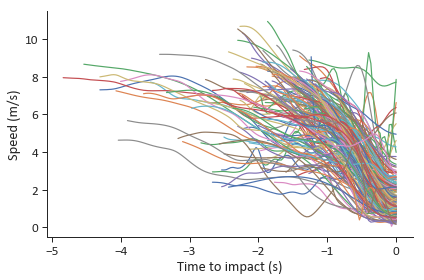

In [30]:
fig, ax = plt.subplots()
for i in np.arange(ntrials):        
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    stt = int(idx_data['descent_start'].iloc[i])
    
    speed = data_dict[i]['speed']
    vel = data_dict[i]['vf_S']
    vel_xy = vel[:,1]
    vel_z = vel[:,2]

    n = len(speed)
    t = np.linspace(0,n,n,False)
    t = t/fs
    t = t-np.max(t)
    
    plt.plot(t[stt:], vel_xy[stt:])

ax.set_ylabel('Speed (m/s)')
ax.set_xlabel('Time to impact (s)')
# ax.axis('scaled')
# ax.set_xlim(-0.6, 0)
# ax.set_ylim(-0.6, 0)
# ax.set_yticks(np.arange(-0.6, 0.1, 0.2))
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("Final-TauTrajectories_v01", dpi=300)

In [58]:
print(idx_data['vert_impact_speed'].describe())
print(idx_data['horz_impact_speed'].describe())
# print(idx_data['tau_dot'].describe())
# print(idx_data['pearson_coef'].describe())
print(idx_data['impact_speed'].describe())
print(idx_data['impact_angle'].describe())
print(idx_data['mean_angle'].describe())
# print(idx_data['distance_after_impact'].describe())

count    177.000000
mean      -1.093488
std        0.452411
min       -3.045852
25%       -1.357403
50%       -1.025802
75%       -0.795554
max       -0.084831
Name: vert_impact_speed, dtype: float64
count    177.000000
mean       4.841701
std        1.477579
min        0.879067
25%        3.832534
50%        4.983222
75%        5.927593
max        8.352632
Name: horz_impact_speed, dtype: float64
count    177.000000
mean       5.018145
std        1.356773
min        1.755407
25%        4.031992
50%        5.087082
75%        5.945644
max        8.483658
Name: impact_speed, dtype: float64
count    177.000000
mean      14.777166
std       10.010146
min        0.593421
25%        8.297821
50%       11.524941
75%       18.359416
max       59.948608
Name: impact_angle, dtype: float64
count    177.000000
mean       8.560573
std        6.326853
min        0.000000
25%        3.928607
50%        7.427872
75%       11.448472
max       36.746727
Name: mean_angle, dtype: float64


In [32]:
idx_data.head()

,date,gopro_vid_id,usable_landings,sex,start_frame,impact_frame,end_frame,rsv_match,rsv_vid_id,number_of_conspecifics,...,tau_dot,pearson_coef,tau_pvalues,tau_r2values,distance_after_impact,vert_impact_speed,horz_impact_speed,impact_speed,impact_angle,mean_angle
1,20170228,A01e,1.0,Male,745.0,820.0,835.0,0.0,NaN,11.0,...,0.981444,0.981136,8.186078e-44,0.962627,0.930321,-1.451275,2.713606,3.077313,28.138507,14.230181
2,20170228,A01f,1.0,Female,50.0,137.0,137.0,0.0,NaN,13.0,...,0.676808,0.977520,2.625732e-44,0.955546,0.000000,-1.888777,6.619487,6.883683,15.925344,12.077003
3,20170305,A03,1.0,Male,4.0,40.0,43.0,0.0,NaN,7.0,...,0.941099,0.999839,3.415716e-59,0.999677,0.765387,-0.352956,7.559674,7.567909,2.673163,1.247092
4,20170305,B01b,1.0,Male,10.0,25.0,50.0,0.0,NaN,3.0,...,0.960736,0.999973,5.073529e-27,0.999947,1.270092,-0.783632,3.812343,3.892049,11.615431,11.589395
5,20170312,C01a,1.0,Female,3.0,20.0,35.0,0.0,NaN,4.0,...,0.991862,0.999990,5.944452e-13,0.999980,1.676704,-0.966370,5.758195,5.838722,9.526894,10.499120


In [30]:
"""Find representative landings"""
# imact speed
mean = idx_data['impact_speed'].mean()
std = idx_data['impact_speed'].std()
imax = idx_data['impact_speed'].max()
imin = idx_data['impact_speed'].min()

upper = mean + std
lower = mean - std
mid_imp_spd = idx_data[(lower < idx_data['impact_speed']) & (idx_data['impact_speed'] < upper)]

high_imp_spd = idx_data[upper < idx_data['impact_speed']]

low_imp_spd = idx_data[idx_data['impact_speed'] < lower]

# impact angle
mean = idx_data['impact_angle'].mean()
std = idx_data['impact_angle'].std()
imax = idx_data['impact_angle'].max()
imin = idx_data['impact_angle'].min()

upper = mean + std
lower = mean - std
mid_imp_ang = idx_data[(lower < idx_data['impact_angle']) & (idx_data['impact_angle'] < upper)]

high_imp_ang = idx_data[upper < idx_data['impact_angle']]

low_imp_ang = idx_data[idx_data['impact_angle'] < lower]

# Approach angle
mean = idx_data['mean_angle'].mean()
std = idx_data['mean_angle'].std()
imax = idx_data['mean_angle'].max()
imin = idx_data['mean_angle'].min()

upper = mean + std
lower = mean - std
mid_app_ang = idx_data[(lower < idx_data['mean_angle']) & (idx_data['mean_angle'] < upper)]

high_app_ang = idx_data[upper < idx_data['mean_angle']]

low_app_ang = idx_data[idx_data['mean_angle'] < lower]


In [31]:
"""Join dataframes to find types of landings"""
high_vel_high_angle = high_imp_spd.reset_index().merge(high_imp_ang, how='inner').set_index('index')
print('high_vel_high_angle', len(high_vel_high_angle.index), high_vel_high_angle.index, '\n')
high_vel_low_angle = high_imp_spd.reset_index().merge(low_imp_ang, how='inner').set_index('index')
print('high_vel_low_angle', len(high_vel_low_angle.index), high_vel_low_angle.index, '\n')
high_vel_mid_angle = high_imp_spd.reset_index().merge(mid_imp_ang, how='inner').set_index('index')
print('high_vel_mid_angle', len(high_vel_mid_angle.index), high_vel_mid_angle.index, '\n')

low_vel_high_angle = low_imp_spd.reset_index().merge(high_imp_ang, how='inner').set_index('index')
print('low_vel_high_angle', len(low_vel_high_angle.index), low_vel_high_angle.index, '\n')
low_vel_low_angle = low_imp_spd.reset_index().merge(low_imp_ang, how='inner').set_index('index')
print('low_vel_low_angle', len(low_vel_low_angle.index), low_vel_low_angle.index, '\n')
low_vel_mid_angle = low_imp_spd.reset_index().merge(mid_imp_ang, how='inner').set_index('index')
print('low_vel_mid_angle', len(low_vel_mid_angle.index), low_vel_mid_angle.index, '\n')

mid_vel_mid_angle = mid_imp_spd.reset_index().merge(mid_imp_ang, how='inner').set_index('index')
print('mid_vel_mid_angle', len(mid_vel_mid_angle.index), mid_vel_mid_angle.index, '\n')
mid_vel_high_angle = mid_imp_spd.reset_index().merge(high_imp_ang, how='inner').set_index('index')
print('mid_vel_high_angle', len(mid_vel_high_angle.index), mid_vel_high_angle.index, '\n')
mid_vel_low_angle = mid_imp_spd.reset_index().merge(low_imp_ang, how='inner').set_index('index')
print('mid_vel_low_angle', len(mid_vel_low_angle.index), mid_vel_low_angle.index, '\n')


high_vel_high_angle 0 Int64Index([], dtype='int64', name='index') 

high_vel_low_angle 6 Int64Index([3, 67, 82, 83, 100, 137], dtype='int64', name='index') 

high_vel_mid_angle 22 Int64Index([  2,  13,  31,  32,  33,  36,  62,  63,  64,  65,  68,  69,  70,
             73,  75,  79,  95,  99, 105, 110, 117, 135],
           dtype='int64', name='index') 

low_vel_high_angle 24 Int64Index([  1,  24,  43,  45,  46,  47,  48, 121, 141, 145, 147, 151, 152,
            153, 157, 158, 160, 162, 163, 168, 169, 171, 173, 175],
           dtype='int64', name='index') 

low_vel_low_angle 1 Int64Index([17], dtype='int64', name='index') 

low_vel_mid_angle 11 Int64Index([9, 44, 78, 88, 91, 143, 146, 166, 167, 172, 174], dtype='int64', name='index') 

mid_vel_mid_angle 105 Int64Index([  4,   5,   6,   7,   8,  10,  11,  12,  14,  15,
            ...
            149, 154, 155, 156, 161, 164, 165, 170, 176, 177],
           dtype='int64', name='index', length=105) 

mid_vel_high_angle 3 Int64Index([50

In [32]:
idx_data.head()

,date,gopro_vid_id,usable_landings,sex,start_frame,impact_frame,end_frame,rsv_match,rsv_vid_id,number_of_conspecifics,...,tau_dot,pearson_coef,tau_pvalues,tau_r2values,distance_after_impact,vert_impact_speed,horz_impact_speed,impact_speed,impact_angle,mean_angle
1,20170228,A01e,1.0,Male,745.0,820.0,835.0,0.0,NaN,11.0,...,0.981444,0.981136,8.186078e-44,0.962627,0.930321,-1.451275,2.713606,3.077313,28.138507,14.230181
2,20170228,A01f,1.0,Female,50.0,137.0,137.0,0.0,NaN,13.0,...,0.676808,0.977520,2.625732e-44,0.955546,0.000000,-1.888777,6.619487,6.883683,15.925344,12.077003
3,20170305,A03,1.0,Male,4.0,40.0,43.0,0.0,NaN,7.0,...,0.941099,0.999839,3.415716e-59,0.999677,0.765387,-0.352956,7.559674,7.567909,2.673163,1.247092
4,20170305,B01b,1.0,Male,10.0,25.0,50.0,0.0,NaN,3.0,...,0.960736,0.999973,5.073529e-27,0.999947,1.270092,-0.783632,3.812343,3.892049,11.615431,11.589395
5,20170312,C01a,1.0,Female,3.0,20.0,35.0,0.0,NaN,4.0,...,0.991862,0.999990,5.944452e-13,0.999980,1.676704,-0.966370,5.758195,5.838722,9.526894,10.499120


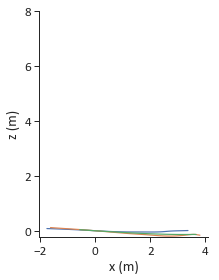

In [33]:
"""Generate a 2D plot of all landing trajectories"""
fig, ax = plt.subplots()
for i in [18, 61, 134]:
    imp = int(idx_data['impact_frame'].loc[i] - idx_data['start_frame'].loc[i])
    stt = int(idx_data['descent_start'].loc[i])

    pf = data_dict[i-1]['pf_S'].copy()

    x = pf[:,1]
    y = pf[:,2]
    imp_x = pf[imp,1]
    imp_y = pf[imp,2]

    x = x - imp_x
    y = y - imp_y
    n = len(x[:])
    t = np.linspace(0,n,n,False)
    t = t/fs
    t = t-t[imp]

    plt.plot(x[stt:],y[stt:])

ax.axis('scaled')    
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
# ax.set_title('Flight trajectories in 2D')
plt.yticks(np.arange(0, 10, 2.0))

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("2D-177-LandingTrajectories_descent_only", dpi=300)

In [61]:
idx_data['mean_angle'].at[77] = 0.001

In [62]:
idx_data[idx_data['mean_angle'] == 0]

,date,gopro_vid_id,usable_landings,sex,start_frame,impact_frame,end_frame,rsv_match,rsv_vid_id,number_of_conspecifics,...,tau_dot,pearson_coef,tau_pvalues,tau_r2values,distance_after_impact,vert_impact_speed,horz_impact_speed,impact_speed,impact_angle,mean_angle


In [30]:
idx_data[idx_data['time_skim'] > 2]

,date,gopro_vid_id,usable_landings,sex,start_frame,impact_frame,end_frame,rsv_match,rsv_vid_id,number_of_conspecifics,notes,descent_start,distance_after_impact,time_skim,vert_impact_speed,horz_impact_speed,impact_speed,impact_angle,mean_angle
96,20181108,A01v,1.0,Female,1361.0,1419.0,1483.0,0.0,NaN,2.0,NaN,27,6.04037,2.168836,-0.763791,4.170863,4.240222,10.377332,0.096264


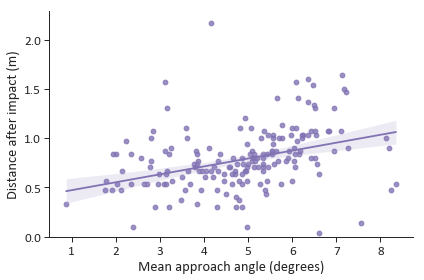

r_squared = 0.120346222409
p-value = 2.24114778324e-06


In [28]:
"""Generalized scatter plot analysis"""
fig, ax = plt.subplots()
x = idx_data['horz_impact_speed']
y = idx_data['time_skim']
# pt_labels = to_plot['rsv_vid_id']

sns.regplot(data=idx_data, x='horz_impact_speed', y='time_skim', robust=True, truncate=True, color='m')
# sns.regplot(data=high_taudot, x='mean_angle', y='distance_after_impact', fit_reg=False, color='b')
# sns.regplot(data=idx_data, x='tau_dot', y='impact_angle')

# df = pd.DataFrame(x, y, pt_labels)
# sns.regplot(data=df, x=x, y=y, fit_reg=False)

# def label_point(x, y, val, ax):
#     a = pd.concat({'x':x, 'y':y, 'val':val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x']+.1, point['y'], str(point['val']))

# label_point(x, y, pt_labels, plt.gca())

# plt.scatter(x,y)

slope, intercept, r_value, p_value, std_error = scipy.stats.linregress(x, y)
r2 = r_value**2
# plt.plot(x, intercept + slope*x, 'g', label='fitted line')

numbers = 'r-square = ' + str(round(r2, 5)) + '\n' + 'p-value = ' + str(round(p_value, 5))
# ax.text(25, 5, numbers, fontsize=12)

ax.set_xlabel('Mean approach angle (degrees)')
ax.set_ylabel('Distance after impact (m)')
ax.set_ylim(bottom=0)
# ax.set_title('Impact speed vs taudot')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("Distance after impact vs mean approach angle", dpi=300)
print(slope)
print('r_squared =', r2)
print('p-value =', p_value)

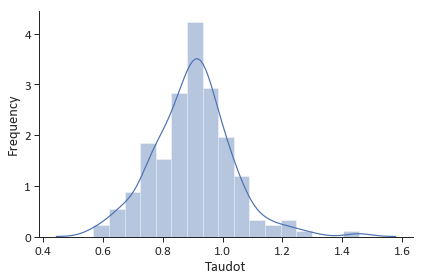

In [35]:
"""Generalized histogram plot"""
fig, ax = plt.subplots()
x = idx_data['tau_dot']

sns.distplot(x)

ax.set_xlabel('Taudot')
ax.set_ylabel('Frequency')
# ax.set_title('Impact speed vs taudot')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("Taudot_histogram", dpi=300)


((array([0.09112931, 0.14449388, 0.18488781, 0.21906504, 0.24949288,
         0.27735246, 0.30331788, 0.32781681, 0.35114072, 0.3734988 ,
         0.3950472 , 0.4159062 , 0.43617075, 0.45591739, 0.47520895,
         0.4940977 , 0.51262777, 0.5308368 , 0.54875722, 0.56641723,
         0.58384155, 0.60105198, 0.61806793, 0.63490672, 0.65158395,
         0.66811371, 0.68450878, 0.70078083, 0.71694056, 0.7329978 ,
         0.74896162, 0.76484045, 0.7806421 , 0.79637387, 0.81204258,
         0.82765465, 0.84321611, 0.85873265, 0.87420967, 0.88965228,
         0.90506535, 0.92045353, 0.93582126, 0.9511728 , 0.96651223,
         0.98184351, 0.99717044, 1.01249668, 1.02782582, 1.04316132,
         1.05850654, 1.07386478, 1.08923926, 1.10463312, 1.12004946,
         1.1354913 , 1.15096165, 1.16646344, 1.1819996 , 1.19757301,
         1.21318653, 1.22884301, 1.24454526, 1.26029611, 1.27609836,
         1.29195482, 1.3078683 , 1.32384161, 1.33987758, 1.35597905,
         1.37214886, 1.38838989, 1

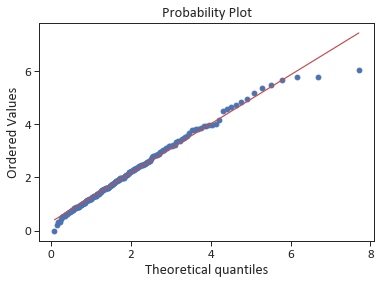

In [36]:
"""Calculate and plot residuals"""
dist = idx_data['distance_after_impact']
# dist.plot.kde()

# resid = np.subtract(dist, dist.mean())
# resid.plot.kde()
# print(resid.mean())

stats.probplot(dist, dist=stats.gamma, sparams=2, plot=plt)


In [48]:
"""General linear regression model"""
var = ['horz_impact_speed', 'vert_impact_speed', 'impact_angle', 'mean_angle']

ind_var = idx_data.loc[:,var]
dep_var = idx_data['distance_after_impact']

# print('Binomial')
# glm_binom = sm.GLM(dep_var, ind_var, family=sm.families.Binomial())
# res = glm_binom.fit()
# print(res.summary())
# print('\n')

print('Gamma')
glm_gamma = sm.GLM(dep_var, ind_var, family=sm.families.Gamma(sm.families.links.log))
res = glm_gamma.fit()
print(res.summary())
print('\n')

# print('Gaussian')
# glm_gaus = sm.GLM(dep_var, ind_var, family=sm.families.Gaussian())
# res = glm_gaus.fit()
# print(res.summary())





Gamma
                   Generalized Linear Model Regression Results                   
Dep. Variable:     distance_after_impact   No. Observations:                  177
Model:                               GLM   Df Residuals:                      173
Model Family:                      Gamma   Df Model:                            3
Link Function:                       log   Scale:                         0.10487
Method:                             IRLS   Log-Likelihood:                    inf
Date:                   Thu, 02 Jan 2020   Deviance:                       88.435
Time:                           16:19:57   Pearson chi2:                     18.1
No. Iterations:                       12   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
horz_impact_speed     0.2156      0.011     19.381      0.000       0.194       0.23

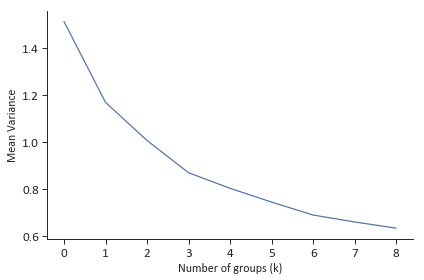

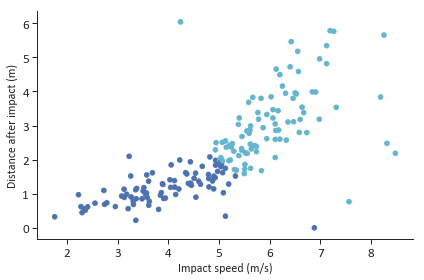

In [38]:
"""Cluster Analysis"""
x = idx_data['impact_speed']
y = idx_data['distance_after_impact']
c = idx_data['tau_dot']

bk = np.stack((x,y,c))
obs = bk.T

cbk = np.array([[1.,1.,1.],
               [2.,2.,2.]])

fig, ax = plt.subplots()
nobs = cluster.whiten(obs)
vect = cluster.vq(nobs,cbk)
k = [cluster.kmeans(nobs, i, iter=20, thresh=1e-5) for i in range(1,10)]
plt.plot([var for (cent,var) in k])

ax.set_xlabel('Number of groups (k)', fontsize=12)
ax.set_ylabel('Mean Variance', fontsize=12)

sns.despine()
plt.tight_layout()
# plt.show()
# plt.savefig('Cluster-norm-KAnalysis.png', dpi=300)


# fig, ax = plt.subplots()
# #nobs = cluster.whiten(obs)
# vect = cluster.vq(obs,cbk)
# k = [cluster.kmeans(obs, i, iter=20, thresh=1e-5) for i in range(1,10)]
# plt.plot([var for (cent,var) in k])

# ax.set_xlabel('Additional centromeres', fontsize=12)
# ax.set_ylabel('Mean Variance to centromere', fontsize=12)

# sns.despine()
# plt.tight_layout()
#plt.show()
#plt.savefig('Cluster-KAnalysis.png', dpi=300)3
cent, var = k[1]
#use vq() to get as assignment for each obs
groups, cdist = cluster.vq(obs,cent)

fig, ax = plt.subplots()
pts = []

from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.color_palette('deep'))
#sns.set_palette(sns.diverging_palette(255, 133, l=60, n=7, center="dark"))
plt.scatter(obs[:,0],obs[:,1], c=groups, cmap=my_cmap) 

# plt.setp(leg.get_title(),fontsize=12, multialignment='center')

# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(traj,vel)
#TrajSpeed_r2 = r_value**2
#TrajSpeed_p_value = p_value
#plt.plot(traj, intercept + slope*traj, 'g', label='fitted line')

ax.set_xlabel('Impact speed (m/s)', fontsize=12)
ax.set_ylabel('Distance after impact (m)', fontsize=12)

sns.despine()
plt.tight_layout()
# plt.show()

# plt.savefig('ImpactSpeed_DistanceAfterImpact_TaudotClusterAnalysis.png', dpi=300)    


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C4CC6AAEF0>,
      dtype=object)

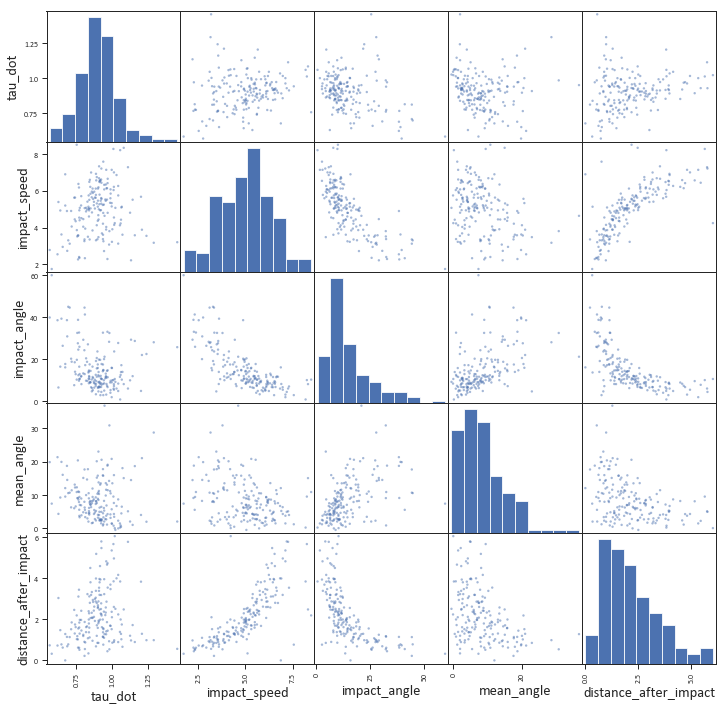

In [39]:
"""Scatter matrix of various parameters"""
scatter_matrix(idx_data[['tau_dot', 'impact_speed', 'impact_angle', 'mean_angle', 'distance_after_impact']], figsize=(12,12))
# scatter_matrix(high_taudot[['tau_dot', 'impact_speed', 'impact_angle', 'mean_angle', 'distance_after_impact']], figsize=(12,12))


In [40]:
idx_data.describe()

,usable_landings,start_frame,impact_frame,end_frame,rsv_match,number_of_conspecifics,descent_start,tau_dot,pearson_coef,tau_pvalues,tau_r2values,distance_after_impact,vert_impact_speed,horz_impact_speed,impact_speed,impact_angle,mean_angle
count,177.0,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,1.760000e+02,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,1.0,330.361582,373.932203,396.694915,0.248588,10.485876,10.576271,0.901053,0.995989,1.746609e-04,0.992138,2.158028,-1.093488,4.841701,5.018145,14.777166,8.558062
std,0.0,391.025000,388.559352,389.384155,0.433420,7.061505,13.392506,0.131160,0.012011,2.062054e-03,0.022740,1.286972,0.452411,1.477579,1.356773,10.010146,6.330356
min,1.0,1.000000,15.000000,34.000000,0.000000,0.000000,1.000000,0.568927,0.862262,0.000000e+00,0.743495,0.000000,-3.045852,0.879067,1.755407,0.593421,-0.444397
25%,1.0,63.000000,117.000000,139.000000,0.000000,5.000000,1.000000,0.821791,0.997156,1.724467e-51,0.994321,1.178175,-1.357403,3.832534,4.031992,8.297821,3.928607
50%,1.0,204.000000,248.000000,269.000000,0.000000,9.000000,6.000000,0.906474,0.999212,6.985901e-36,0.998424,1.884103,-1.025802,4.983222,5.087082,11.524941,7.427872
75%,1.0,448.000000,482.000000,498.000000,0.000000,13.000000,15.000000,0.969806,0.999881,9.358799e-24,0.999761,2.866063,-0.795554,5.927593,5.945644,18.359416,11.448472
max,1.0,2253.000000,2271.000000,2296.000000,1.000000,34.000000,79.000000,1.454423,1.000000,2.715124e-02,1.000000,6.040370,-0.084831,8.352632,8.483658,59.948608,36.746727


In [41]:
high_taudot = idx_data[idx_data['tau_dot'] > 1]
low_taudot = idx_data[idx_data['tau_dot'] < 1]



In [42]:
high_taudot.describe()

,usable_landings,start_frame,impact_frame,end_frame,rsv_match,number_of_conspecifics,descent_start,tau_dot,pearson_coef,tau_pvalues,tau_r2values,distance_after_impact,vert_impact_speed,horz_impact_speed,impact_speed,impact_angle,mean_angle
count,32.0,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,3.200000e+01,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,1.0,329.968750,372.18750,396.437500,0.093750,12.406250,14.656250,1.091032,0.996855,2.194832e-10,0.993736,2.321989,-0.971470,4.880631,5.017174,13.256070,6.895604
std,0.0,392.642946,401.35532,404.155985,0.296145,8.253482,13.547073,0.099655,0.004048,1.198430e-09,0.008046,1.656091,0.388747,1.709722,1.628928,8.193047,7.459195
min,1.0,1.000000,25.00000,34.000000,0.000000,2.000000,1.000000,1.001090,0.986127,0.000000e+00,0.972446,0.561013,-1.711408,1.943825,2.225678,0.593421,-0.444397
25%,1.0,38.750000,86.25000,103.000000,0.000000,7.750000,3.000000,1.019692,0.996829,3.516084e-41,0.993668,0.981503,-1.357061,3.580782,3.815745,7.652746,1.312507
50%,1.0,240.500000,260.50000,288.000000,0.000000,10.500000,13.500000,1.059869,0.998863,9.705859e-32,0.997727,1.731667,-0.863377,4.622502,4.673815,10.222957,4.183787
75%,1.0,408.250000,443.25000,475.250000,0.000000,14.500000,23.250000,1.128684,0.999410,5.200861e-22,0.998820,3.829408,-0.725559,6.036545,6.074000,18.187208,10.532269
max,1.0,1369.000000,1433.00000,1483.000000,1.000000,33.000000,48.000000,1.454423,1.000000,6.782859e-09,1.000000,6.040370,-0.084831,8.237998,8.317471,29.148173,28.705609


In [43]:
low_taudot.describe()

,usable_landings,start_frame,impact_frame,end_frame,rsv_match,number_of_conspecifics,descent_start,tau_dot,pearson_coef,tau_pvalues,tau_r2values,distance_after_impact,vert_impact_speed,horz_impact_speed,impact_speed,impact_angle,mean_angle
count,145.0,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,1.440000e+02,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,1.0,330.448276,374.317241,396.751724,0.282759,10.062069,9.675862,0.859126,0.995798,2.134744e-04,0.991786,2.121843,-1.120416,4.833110,5.018359,15.112856,8.924950
std,0.0,392.032346,387.104686,387.491192,0.451901,6.729104,13.236042,0.095379,0.013137,2.279305e-03,0.024847,1.194422,0.462154,1.427831,1.295642,10.363011,6.020875
min,1.0,2.000000,15.000000,35.000000,0.000000,0.000000,1.000000,0.568927,0.862262,1.163504e-159,0.743495,0.000000,-3.045852,0.879067,1.755407,1.688364,0.899074
25%,1.0,66.000000,124.000000,146.000000,0.000000,5.000000,1.000000,0.801898,0.997578,4.029415e-56,0.995162,1.246246,-1.357403,3.866633,4.055613,8.482773,4.361549
50%,1.0,198.000000,241.000000,269.000000,0.000000,9.000000,5.000000,0.882687,0.999405,1.502149e-37,0.998810,1.918304,-1.042716,4.986251,5.144157,11.615431,7.914395
75%,1.0,460.000000,482.000000,498.000000,1.000000,13.000000,13.000000,0.928181,0.999895,3.454781e-24,0.999791,2.855348,-0.811051,5.907663,5.942939,18.359416,11.448472
max,1.0,2253.000000,2271.000000,2296.000000,1.000000,34.000000,79.000000,0.999399,1.000000,2.715124e-02,1.000000,5.782242,-0.209941,8.352632,8.483658,59.948608,36.746727


In [44]:
factors = ['impact_speed', 'impact_angle', 'mean_angle', 'distance_after_impact']
def normalize(s):
    s_norm = np.norm

for i in factors:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-44-c4d8dc3eebbc>, line 6)

In [ ]:
print('Impact speed: ', scipy.stats.mannwhitneyu(low_taudot['impact_speed'], high_taudot['impact_speed']))
print('Impact angle: ', scipy.stats.mannwhitneyu(low_taudot['impact_angle'], high_taudot['impact_angle']))
print('Mean angle: ', scipy.stats.mannwhitneyu(low_taudot['mean_angle'], high_taudot['mean_angle']))
print('Distance after impact: ', scipy.stats.mannwhitneyu(low_taudot['distance_after_impact'], high_taudot['distance_after_impact']))

In [45]:
idx_data.to_csv('TestDirectory/IdxDataExport.csv')